In [1]:
import sys
sys.path.append('../../bats_transformer')

In [2]:
from argparse import ArgumentParser
import torch
import numpy as np

import pytorch_lightning as pl
import spacetimeformer as stf
import pandas as pd

from pytorch_lightning.loggers import WandbLogger
from data import preprocess
import time
import tqdm
from itertools import chain
from data.bats_dataset import *
from pytorch_lightning.callbacks import LearningRateMonitor

from itertools import chain
from utils import *

In [3]:
# dataset_path = "../../bats_transformer/data/daytime_files_new/splits"
# model_path = "../../bats_transformer/models/daytime_files_new_10_11/models_31"

dataset_path = "../../bats_transformer/data/filter_test/splits"
model_path = "../../bats_transformer/models/laci_daytime_10_15/model_31"

In [4]:
ignore_cols = ["FreqLedge","AmpK@end", "Fc", "FBak15dB  ", "FBak32dB", "EndF", "FBak20dB", "LowFreq", "Bndw20dB", 
               "CallsPerSec", "EndSlope", "SteepestSlope", "StartSlope", "Bndw15dB", "HiFtoUpprKnSlp", "HiFtoKnSlope", 
               "DominantSlope", "Bndw5dB", "PreFc500", "PreFc1000", "PreFc3000", "KneeToFcSlope", "TotalSlope", 
               "PreFc250", "CallDuration", "CummNmlzdSlp", "DurOf32dB", "SlopeAtFc", "LdgToFcSlp", "DurOf20dB", "DurOf15dB", 
               "TimeFromMaxToFc", "KnToFcDur", "HiFtoFcExpAmp", "AmpKurtosis", "LowestSlope", "KnToFcDmp", "HiFtoKnExpAmp", 
               "DurOf5dB", "KnToFcExpAmp", "RelPwr3rdTo1st", "LnExpB_StartAmp", "Filter", "HiFtoKnDmp", "LnExpB_EndAmp", 
               "HiFtoFcDmp", "AmpSkew", "LedgeDuration", "KneeToFcResidue", "PreFc3000Residue", "AmpGausR2", "PreFc1000Residue", 
               "Amp1stMean", "LdgToFcExp", "FcMinusEndF", "Amp4thMean", "HiFtoUpprKnExp", "HiFtoKnExp", "KnToFcExp", "UpprKnToKnExp", 
               "Kn-FcCurviness", "Amp2ndMean", "Quality", "HiFtoFcExp", "LnExpA_EndAmp", "RelPwr2ndTo1st", "LnExpA_StartAmp", 
               "HiFminusStartF", "Amp3rdMean", "PreFc500Residue", "Kn-FcCurvinessTrndSlp", "PreFc250Residue", "AmpVariance", "AmpMoment", 
               "meanKn-FcCurviness", "MinAccpQuality", "AmpEndLn60ExpC", "AmpStartLn60ExpC", "Preemphasis", "MaxSegLnght" ,"Max#CallsConsidered" ]
ignore_cols += ["Filename", "NextDirUp", 'Path', 'Version', 'Filter', 'Preemphasis', 'MaxSegLnght', "ParentDir", "file_id", "chirp_idx", "split"]

In [5]:
data_module = stf.data.DataModule(
    datasetCls = BatsCSVDatasetWithMetadata,
    dataset_kwargs = {
        "root_path": dataset_path,
        "prefix": "split",
        "ignore_cols": ignore_cols,
        "metadata_cols": ["file_id", "chirp_idx"],
        "time_col_name": "TimeIndex",
        "val_split": 0.05,
        "test_split": 0.05,
        "context_points": None,
        "target_points": 1,
    },
    batch_size=64,
    workers=4
)

In [6]:
model = stf.spacetimeformer_model.Spacetimeformer_Forecaster(max_seq_len = 54).load_from_checkpoint(checkpoint_path=model_path)

Forecaster
	L2: 0.001
	Linear Window: 0
	Linear Shared Weights: False
	RevIN: False
	Decomposition: False
GlobalSelfAttn: AttentionLayer(
  (inner_attention): PerformerAttention(
    (kernel_fn): ReLU()
  )
  (query_projection): Linear(in_features=200, out_features=200, bias=True)
  (key_projection): Linear(in_features=200, out_features=200, bias=True)
  (value_projection): Linear(in_features=200, out_features=200, bias=True)
  (out_projection): Linear(in_features=200, out_features=200, bias=True)
  (dropout_qkv): Dropout(p=0.0, inplace=False)
)
GlobalCrossAttn: AttentionLayer(
  (inner_attention): PerformerAttention(
    (kernel_fn): ReLU()
  )
  (query_projection): Linear(in_features=200, out_features=200, bias=True)
  (key_projection): Linear(in_features=200, out_features=200, bias=True)
  (value_projection): Linear(in_features=200, out_features=200, bias=True)
  (out_projection): Linear(in_features=200, out_features=200, bias=True)
  (dropout_qkv): Dropout(p=0.0, inplace=False)
)
L

In [7]:
test_data = data_module.test_dataloader()
batch = next(iter(test_data))  # Get a batch of data
batch = batch[0]
batch.shape

torch.Size([64, 31, 1])

In [8]:
x_c_batch, y_c_batch, x_t_batch, y_t_batch, metadata = next(iter(test_data))
# y_hat_t = spacetimeformer_predict(model, x_c_batch, y_c_batch, x_t_batch)
y_hat_t = spacetimeformer_predict(model, x_c_batch, y_c_batch, x_t_batch)

In [9]:
print(x_c_batch.shape)
print(y_c_batch.shape)
print(x_t_batch.shape)
print(y_t_batch.shape)
print(y_hat_t.shape)

torch.Size([64, 31, 1])
torch.Size([64, 31, 28])
torch.Size([64, 1, 1])
torch.Size([64, 1, 28])
torch.Size([64, 1, 28])


In [10]:
x_c_first = x_c_batch[0]
y_c_first = y_c_batch[0]
x_t_first = x_t_batch[0]
y_t_first = y_t_batch[0]
y_hat_first = y_hat_t[0]

In [11]:
print(x_c_first)
print(y_c_first)
print(x_t_first)
print(y_t_first)
print(y_hat_first)

tensor([[-1.6787],
        [-1.5704],
        [-1.4621],
        [-1.3538],
        [-1.2455],
        [-1.1372],
        [-1.0289],
        [-0.9206],
        [-0.8123],
        [-0.7040],
        [-0.5957],
        [-0.4874],
        [-0.3791],
        [-0.2708],
        [-0.1625],
        [-0.0542],
        [ 0.0542],
        [ 0.1625],
        [ 0.2708],
        [ 0.3791],
        [ 0.4874],
        [ 0.5957],
        [ 0.7040],
        [ 0.8123],
        [ 0.9206],
        [ 1.0289],
        [ 1.1372],
        [ 1.2455],
        [ 1.3538],
        [ 1.4621],
        [ 1.5704]])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.00

In [12]:
predicted_trajectory = torch.cat((y_c_first, y_hat_first), dim=0)
true_trajectory = torch.cat((y_c_first, y_t_first), dim=0)

(15.0, 33.0)

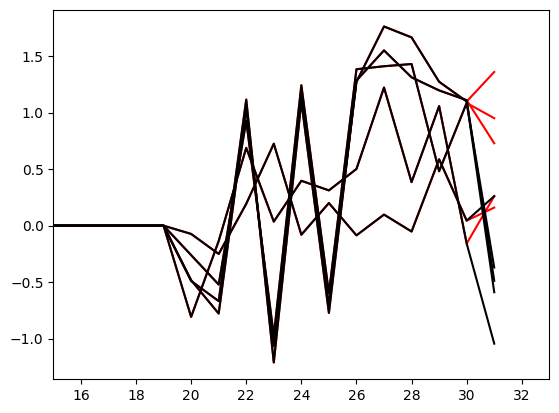

In [17]:
import matplotlib.pyplot as plt
plt.plot(predicted_trajectory.numpy()[:,5:10], c='red')
plt.plot(true_trajectory.numpy()[:,5:10], c='black')
plt.xlim(15,33)

In [14]:
y_hat_t

tensor([[[ 0.9768,  0.2262,  0.7494,  ...,  0.2812,  0.9307,  0.6694]],

        [[ 1.2814,  0.2543,  1.2132,  ...,  0.5579,  0.3660,  0.3030]],

        [[ 0.2414,  0.2199,  1.0651,  ...,  0.5647,  0.4533,  0.3843]],

        ...,

        [[ 1.8473,  0.2496, -0.6903,  ..., -0.0525, -0.3097, -0.1241]],

        [[ 1.6613,  0.4683, -0.3711,  ..., -0.0300, -0.0347, -0.1058]],

        [[ 1.4327,  0.6040, -0.2826,  ...,  0.0466, -0.3476,  0.0308]]])

In [15]:
for batch in tqdm.tqdm(data_module.test_dataloader()):
    
    x_c_batch, y_c_batch, x_t_batch, y_t_batch, metadata = batch
    # y_hat_t = spacetimeformer_predict(model, x_c_batch, y_c_batch, x_t_batch)
    y_hat_t = spacetimeformer_predict(model, x_c_batch, y_c_batch, x_t_batch)

100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
